In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('TCGA-PANCAN-HiSeq-801x20531/data.csv', index_col = 0)
labels = pd.read_csv('TCGA-PANCAN-HiSeq-801x20531/labels.csv')

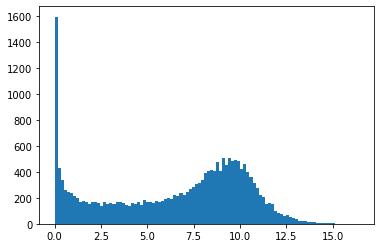

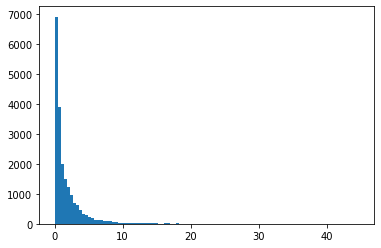

In [3]:
mean_arr = np.mean(data, 0)
var_arr = np.var(data, 0)
plt.hist(mean_arr, 100)
plt.show()
plt.hist(var_arr, 100)
plt.show()

In [4]:
print('There are %s constant features.' % len(np.argwhere(np.array(var_arr == 0))))

There are 267 constant features.


In [5]:
data_new = data.drop(data.columns[np.argwhere(np.array(var_arr == 0)).flatten()], axis = 1)
mean_arr = np.mean(data_new, 0)
var_arr = np.var(data_new, 0)
min_var = 2
data_new.drop(data_new.columns[np.argwhere(np.array(var_arr < min_var)).flatten()], axis = 1, inplace = True)
mean_arr = np.mean(data_new, 0)
var_arr = np.var(data_new, 0)
print(data_new.shape)

(801, 5579)


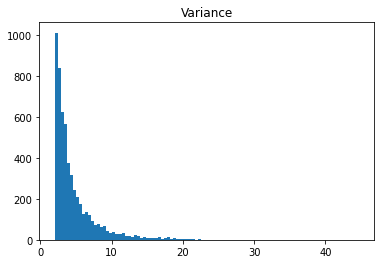

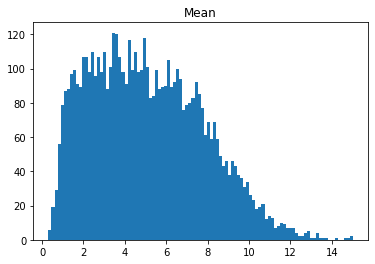

In [6]:
plt.hist(var_arr, 100)
plt.title('Variance')
plt.show()
plt.hist(mean_arr, 100)
plt.title('Mean')
plt.show()

In [7]:
data_new_standardized = (data_new - mean_arr)/(var_arr ** (1/2))

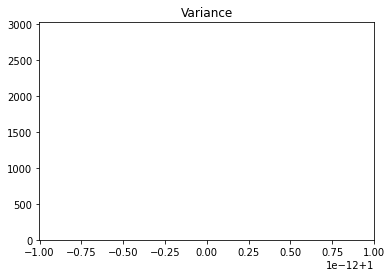

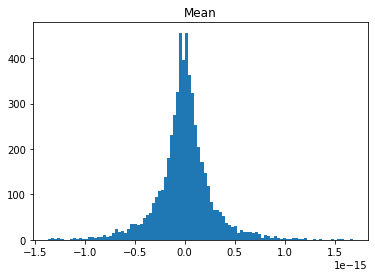

In [8]:
mean_arr = np.mean(data_new_standardized, 0)
var_arr = np.var(data_new_standardized, 0)
plt.hist(var_arr)
plt.title('Variance')
plt.show()
plt.hist(mean_arr, 100)
plt.title('Mean')
plt.show()

In [9]:
cov = 

(801, 5579)
